In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import matplotlib

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams["font.size"] = 20

import mne
import microstates
from scipy.signal import find_peaks

#matplotlib.use('Qt5Agg')
#%matplotlib qt

#%matplotlib inline

import importlib
#import foo #import the module here, so that it can be reloaded.
importlib.reload(microstates)



<module 'microstates' from '/Users/giacomobarzon/Desktop/EEG-microstates/microstates.py'>

# Microstates - Individual

In [3]:
n_subj = 3
folder = '/Users/giacomobarzon/Desktop/EEG-microstates/data/eeg_cognitive_control/'
fs = 100 #Hz
low_freq = 2
high_freq = 20
dt = 1 / fs
min_peak_dist = 1

pick_only_resting = False

data_to_cluster = []

for i in range(n_subj):
    # Load data
    fname = folder + 'ss0'+str(i+1)+'_clean.set'
    raw = mne.io.read_raw_eeglab(fname, preload=True)
        
    # Filter data and resample
    raw.filter(low_freq, high_freq)
    raw.resample(fs)
    
    if i==0:
        # Store info for plotting
        channels = mne.pick_types(raw.info, meg=False, eeg=True)
        info = mne.pick_info(raw.info, channels)
    
    # Get data
    #channels = mne.pick_types(raw.info, meg=False, eeg=True)
    data = raw.get_data(picks=channels, reject_by_annotation='omit')
    print('data shape:', data.shape)
    
    if pick_only_resting:
        # Get events
        events, events_id = mne.events_from_annotations(raw)
        # Get only resting data
        if events[0][2] == events_id['Task']:
            data = data[:,:events[0][0]]
            print('resting shape:', data.shape)
        else:
            print('TASK EVENT NOT FOUND...')
        
    # Get GFP peaks
    gfp = np.std(data, axis=0)
    peaks, _ = find_peaks(gfp, distance=min_peak_dist)
    print('Number of GFP peaks: %d' % len(peaks))
    
    # Store data
    data_to_cluster.append(data[:,peaks])
    
del raw, data, events, gfp, peaks

data_to_cluster = np.hstack(data_to_cluster)
print('\n\nConcatenated data shape: ', data_to_cluster.shape)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mne/externals/pymatreader/utils.py:118: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Reading /Users/giacomobarzon/Desktop/EEG-microstates/data/eeg_cognitive_control/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 825 samples (1.650 sec)

data shape: (64, 488000)
Used Annotations descriptions: ['S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172', 'Task']
Number of GFP peaks: 102113
Reading /Users/giacomobarzon/Desktop/EEG-microstates/data/eeg_cognitive_control/ss02_clean.fdt
R

# Microstates

In [4]:
# Segment the data into microstates
n_states=4
states = np.arange(n_states)
maps, segmentation = microstates.segment(data_to_cluster, n_states=n_states, max_n_peaks=None)

#del segmentation, data_to_cluster

[+] EEG microstates

Data shape: (64,292864)
Finding 4 microstates, using 10 random intitializations
Converged at 110 iterations.
GEV of found microstates: 72.173118 %
Converged at 51 iterations.
GEV of found microstates: 72.474782 %
Converged at 125 iterations.
GEV of found microstates: 72.476225 %
Converged at 60 iterations.
GEV of found microstates: 72.476284 %
Converged at 120 iterations.
GEV of found microstates: 72.464798 %
Converged at 109 iterations.
GEV of found microstates: 72.464800 %
Converged at 131 iterations.
GEV of found microstates: 72.476201 %
Converged at 40 iterations.
GEV of found microstates: 72.476305 %
Converged at 44 iterations.
GEV of found microstates: 72.476663 %
Converged at 39 iterations.
GEV of found microstates: 72.476444 %
Best GEV of found microstates: 72.476663 %


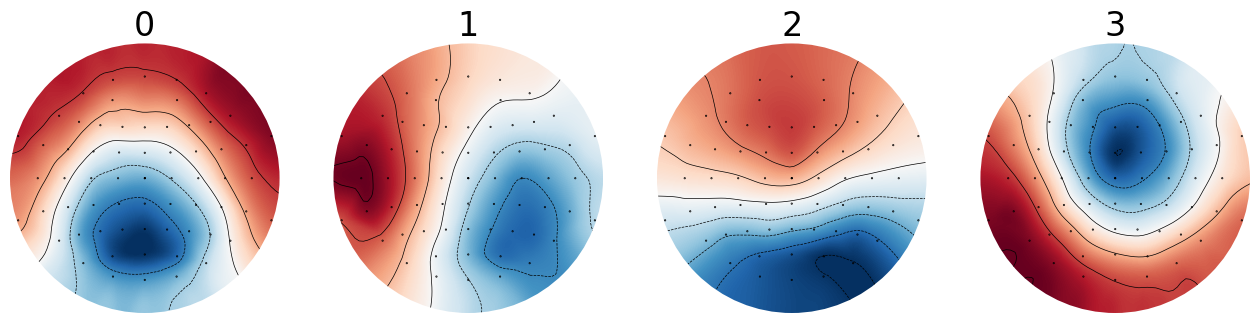

In [5]:
# Plot the topographic maps of the found microstates
microstates.plot_maps(maps, info)

# Distributions & transition probabilities

In [8]:
def get_segmentation(data, maps, interpolation=True):
    if interpolation:
        gfp = np.std(data, axis=0)
        peaks, _ = find_peaks(gfp, distance=min_peak_dist)
        
        # Define empty microstates vector
        states = np.zeros(len(gfp))
        
        # Get microstates at GFP peaks
        activation = maps.dot(data[:,peaks])
        states_at_peaks = np.argmax(np.abs(activation), axis=0)
        
        # Interpolate between GFP peaks
        for i in range(1,len(peaks)-1):
            states[peaks[i]-(peaks[i]-peaks[i-1])//2:peaks[i]+(peaks[i+1]-peaks[i] +1)//2] += states_at_peaks[i]
        states[:peaks[0]+(peaks[1]-peaks[0] +1)//2] += states_at_peaks[0] # first peak
        states[peaks[-1]-(peaks[-1]-peaks[-2])//2:] += states_at_peaks[-1] # last peak
    else:    
        activation = maps.dot(data)
        states = np.argmax(np.abs(activation), axis=0)
    
    return states

# Lifetimes
def get_lifetimes(data, states, average=True):
    from itertools import groupby
    
    # count consecutive occurrences
    grouped = [[k, sum(1 for _ in g)] for k,g in groupby(data)]
    grouped = np.array(grouped)
    
    lifes = []
    
    # loop over states
    for i, state in enumerate(states):
        # keep only considered state
        tmp = grouped[:,1][grouped[:,0]==state]
        
        if average:
            tmp = np.mean(tmp)
        lifes.append(tmp)
    
    if average:
        lifes = np.array(lifes)
        
    return lifes

def count_occur(data, states):
    # count microstates occurrence
    counts = np.zeros(len(states))
    
    for i, state in enumerate(states):
        counts[i] = np.sum(data==state)

    return counts.astype(int)

def count_joint_occur(data, states):
    # Compute joint matrix
    n_states = len(states)
    q_matrix = np.zeros((n_states,n_states))

    for i in range(n_states):
        # init state
        s_in = data[:-1] == states[i]
    
        for j in range(i, n_states):
            # ending state
            s_out = data[1:] == states[j]
            # count occurrences
            q_matrix[i,j] = np.sum(s_in*s_out)
        
    # simmetrize matrix
    q_matrix += q_matrix.T - np.diag(q_matrix.diagonal())
    
    return q_matrix

def get_prob(data, states):
    counts = count_occur(data, states)
    return counts / np.sum(counts)

def get_q_matrix(data, states):
    q_matrix = count_joint_occur(data, states)
    
    return q_matrix / q_matrix.sum()

def get_t_matrix(data, states):
    t_matrix = count_joint_occur(data, states)
    # normalize each row
    t_matrix = t_matrix / t_matrix.sum(axis=1)[:,None]
    
    return t_matrix

def plot_distributions(prob, t_matrix):
    plt.figure(figsize=(16,4))

    # probability distribution
    plt.subplot(1,2,1)

    plt.bar(states.astype(str), prob)

    plt.xlabel('state')
    plt.ylabel('prob')

    # transition matrix
    plt.subplot(1,2,2)

    plt.imshow(t_matrix, extent=[0,n_states,0,n_states], cmap='summer')

    for i in range(n_states):
        for j in range(n_states):
            plt.text(j+0.2, n_states-1-i+0.4, '{:0.3f}'.format(t_matrix[i,j]))

    plt.xticks(states+0.5, labels=states)
    plt.yticks(states+0.5, labels=states[::-1])

    plt.xlabel('state t+1')
    plt.ylabel('state t')
    plt.colorbar()

    plt.show()

def plot_segmentation(data, T0=100, T=100):
    cs = ['yellow', 'blue', 'green', 'red']

    times = np.arange(T0,T0+T) * dt * 1e3

    gfp = np.std(data, axis=0)[T0:T0+T]
    segment = segmentation[T0:T0+T]

    peaks, _ = find_peaks(gfp, distance=min_peak_dist)

    plt.figure(figsize=(10,4))
    plt.plot(times, gfp, c='k', lw=2)

    for state in states:
        plt.fill_between(times, np.min(gfp), np.max(gfp), where=(segment==state), facecolor=cs[state], alpha=0.4, label=state, step='pre')
    
    plt.xlim([times[0], times[-1]])
    plt.ylim([np.min(gfp), 6.5e-6])
    plt.xlabel('t[ms]')
    plt.ylabel(r'$GFP[\mu V]$')
    plt.grid()
    plt.legend(mode = "expand", ncol=5)
    plt.show()

In [11]:
n_subj = 3

occurs_all = []
joint_occurs_all = []
length_all = []

for i in range(n_subj):
    print('\n\n[*] ---------- SUBJECT %d ----------' % (i+1))

    print('[+] Extracting data...')
    fname = folder + 'ss0'+str(i+1)+'_clean.set'
    raw = mne.io.read_raw_eeglab(fname, preload=True)
    raw.filter(low_freq, high_freq)
    raw.resample(fs)

    events, events_id = mne.events_from_annotations(raw)

    data = raw.get_data()
    
    epochs = mne.Epochs(raw, events, tmin=0, tmax=4., baseline=None, event_id=events_id)

    tasks = ['S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'rest', 'all']
    n_tasks = len(tasks)

    # Init empty matrices
    occurs = np.zeros((n_tasks, n_states))
    joint_occurs = np.zeros((n_tasks, n_states, n_states))
    lifes = np.zeros((n_tasks, n_states))
    length = np.zeros(n_tasks)

    for i, task in enumerate(tasks):
        print('[+] Task: %s' % task)
        tmp_lifes = []
        # Get data
        if task=='rest':
            # Get only resting data
            if events[0][2] == events_id['Task']:
                task_data = data[:,:events[0][0]]
            else:
                print('TASK EVENT NOT FOUND...')
        elif task=='all':
            task_data = data
        else:
            task_data = epochs[task].get_data(picks='eeg')
    
        if len(task_data.shape)<3:
            task_data = np.expand_dims(task_data, axis=0)
        print('data shape:', task_data.shape)
        length[i] = task_data.shape[0] * task_data.shape[2]
    
        # Loop over trials
        for trial in task_data:
            # get segmentation
            segmented = get_segmentation(trial, maps)
        
            ## count occurrences for probability
            occurs[i] += count_occur(segmented, states)
        
            ## count occurrences for transition matrix
            joint_occurs[i] += count_joint_occur(segmented, states)
        
            ## get lifetimes
            tmp_lifes = tmp_lifes + get_lifetimes(segmented, states, average=False)
        #lifes[i] = np.mean(tmp_lifes)
     
    # Store results
    occurs_all.append(occurs)
    joint_occurs_all.append(joint_occurs)
    length_all.append(length)



[*] ---------- SUBJECT 1 ----------
[+] Extracting data...


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mne/externals/pymatreader/utils.py:118: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Reading /Users/giacomobarzon/Desktop/EEG-microstates/data/eeg_cognitive_control/ss01_clean.fdt
Reading 0 ... 2439999  =      0.000 ...  4879.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 825 samples (1.650 sec)

Used Annotations descriptions: ['S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172', 'Task']
Not setting metadata
Not setting metadata
801 matching events found
No baseline correction applied
0 projection items activated
[+] Task: S 21
Loadin

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mne/externals/pymatreader/utils.py:118: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Reading /Users/giacomobarzon/Desktop/EEG-microstates/data/eeg_cognitive_control/ss02_clean.fdt
Reading 0 ... 2213499  =      0.000 ...  4426.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 825 samples (1.650 sec)

Used Annotations descriptions: ['S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172', 'Task']
Not setting metadata
Not setting metadata
801 matching events found
No baseline correction applied
0 projection items activated
[+] Task: S 21
Loadin

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mne/externals/pymatreader/utils.py:118: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Reading /Users/giacomobarzon/Desktop/EEG-microstates/data/eeg_cognitive_control/ss03_clean.fdt
Reading 0 ... 2382499  =      0.000 ...  4764.998 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 825 samples (1.650 sec)

Used Annotations descriptions: ['S 21', 'S 22', 'S 51', 'S 52', 'S 71', 'S 72', 'S121', 'S122', 'S151', 'S152', 'S171', 'S172', 'Task']
Not setting metadata
Not setting metadata
801 matching events found
No baseline correction applied
0 projection items activated
[+] Task: S 21
Loadin

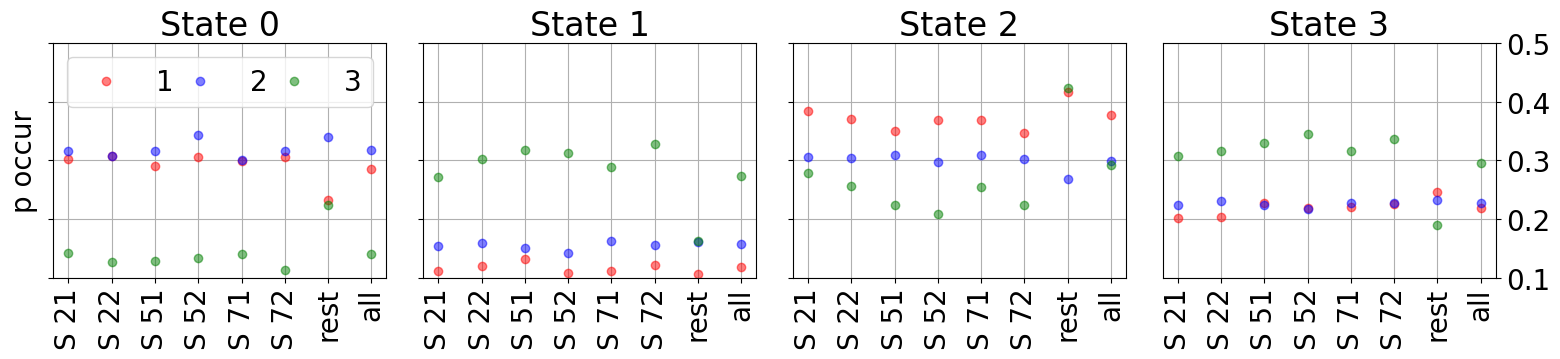

In [10]:
cs = ['red', 'blue', 'green']

plt.figure(figsize=(16,4))

for state in states:
    ax = plt.subplot(1,4,state+1)
    
    for subj in range(n_subj):
        plt.plot(occurs_all[subj][:,state]/length_all[subj], 'o', c=cs[subj], alpha=0.5, label=subj+1)
    
    plt.ylim([0.1, 0.5])
    ax.grid(True)
    if state==0:
        plt.ylabel('p occur')
        plt.legend(mode = "expand", ncol=3)
    if state == n_states-1:
        ax.yaxis.tick_right()
    else:
        ax.set_yticklabels([])
    plt.xticks(ticks=range(n_tasks), labels=tasks, rotation=90)
    plt.title('State %d' % state)

plt.tight_layout()  
plt.show()

In [ ]:
prob = get_prob(segmentation, states)
q_matrix = get_q_matrix(segmentation, states)
t_matrix = get_t_matrix(segmentation, states)

plot_distributions(prob, t_matrix)

In [ ]:
lifes = get_lifetimes(segmentation, states, average=False)
lifes_avg = get_lifetimes(segmentation, states)
np.set_printoptions(precision=3)
print('Microstates lifetimes (ms):', lifes_avg * dt * 1e3)

In [ ]:
plt.figure(figsize=(16,4))

for i, state in enumerate(states):
    ax = plt.subplot(1,4,i+1)
    
    logbins = np.logspace(np.log10(np.min(lifes[i]*dt*1e3)),np.log10(np.max(lifes[i]*dt*1e3)),30)
    
    plt.hist(lifes[i]*dt*1e3, bins=logbins, density=True)
    
    plt.xscale('log')
    plt.yscale('log')
    
    plt.xlabel('lifetime[ms]')
    if i==0:
        plt.ylabel('pdf')
    if i<len(states)-1:
        plt.yticks([])
    else:
        ax.yaxis.tick_right()
        
    #plt.xticks([5e1, 1e2, 5e2])

    plt.title('State %d' % state)

plt.tight_layout()
plt.show()

# Transition cost

In [ ]:
# start matlab engine
import matlab.engine

eng = matlab.engine.start_matlab()
eng.addpath('SB_toolbox-main', nargout=0)

In [ ]:
# convert empirical distributions to Matlab arrays
ini_dist = matlab.double(p_rest.reshape(-1,1).tolist())
Q = matlab.double(q_rest.tolist())

Ps = []

for i, task in enumerate(tasks):

    tar_dist = matlab.double(prob_task[i].reshape(-1,1).tolist())
    
    P = eng.solveSBP(ini_dist,tar_dist,Q)
    Ps.append(P)

In [ ]:
plt.figure(figsize=(8,5))

#plt.bar(['high', 'medium', 'low'], Ps)
plt.bar(tasks, Ps)

plt.ylabel('cost', size=size)
plt.xlabel('stimulus', size=size)
plt.title('Transition cost - resting to task', size=size+4)

plt.show()

In [ ]:
raw

In [ ]:
tt = np.zeros(20)

In [ ]:
count_occur(tt, states)

In [ ]:
states

In [ ]:
tmp = get_lifetimes(segmentation, states)

In [ ]:
np.mean(tmp[0]) * dt * 1e3

In [ ]:
dt * 